# Attribution Demo with the MIND dataset

In [1]:
import pandas as pd
import numpy as np
from xnrs.explain import MindExplainer
from xnrs.evaluation import visualization as vis
from xnrs.models import get_checkpoint

/mount/arbeitsdaten/tcl/Users/moellels/anaconda/envs/xnrs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialization

You can use the `get_checkpoint()` method to load one of our pre-trained models from the web and store the checkpoint in the defined directory.
"xnrs_mind" is an explainable model implementing our standard archtiecture (details in the paper) that is trained on the MIND dataset.

In [2]:
get_checkpoint(
    name='xnrs_mind',
    dst_dir='checkpoints/'
)

ready


After downloading the model, we initialize our `MindExplainer` wrapper and load the model into it.
It is a subclass of the general `Explainer` and also provides a functionalities to load the pre-processed MIND dataset. For this to work you need to have run the `xnrs.data.make_mind_dataset.py` script that takes care of preparing the raw dataset. Then, make sure that the below `news_path` and `user_path` point to the created files. The first time, loading the dataset will take a while.

In [3]:
model_path = 'checkpoints/xnrs_mind_checkpoint'
news_path = '/mount/arbeitsdaten/tcl/data/mind/MINDlarge_dev/news_full_smpnet_test.pkl'
user_path = '/mount/arbeitsdaten/tcl/data/mind/MINDlarge_dev/behaviors.csv'

print('init explainer')
explainer = MindExplainer()
print('loading model checkpoint')
explainer.load_checkpoint(path=model_path, device='cuda:0')
print('loading data')
explainer.load_data(
    news_path=news_path,
    user_path=user_path
)

init explainer
loading model checkpoint
loading data


## Sampling a Session

MIND is organized into reading sessions of individual users. We first sample and random session with a user that has read at least ten news and score all candidate recommendations in this session using the `Explainer`'s `sample_random_session()` and `score_session()` methods.

In [9]:
session_idx = explainer.sample_random_session(min_hist_len=10)
batch, scores, u, c = explainer.score_session(session_idx, return_embeddings=True)

The returned batch contains all candidate news:

In [10]:
batch['candidate_features']['title']

["WH record of Trump's 1st call with Ukraine president differs from earlier description",
 'Fashion hits and misses from the 2019 Country Music Association Awards',
 'A $15 latte shows how the supply of premium coffee is shrinking',
 "Camille Grammer Accuses Ex-Husband Kelsey Grammer of 'Rewriting History'",
 'South Carolina teen gets life in prison for deadly elementary school shooting',
 'Five Great Holiday Cruises Worth Taking',
 'Trump attacks ambassador on Twitter as she testifies that his words in Ukraine call made her feel threatened',
 'Golfer and girlfriend pull amazing trick shot',
 '66 Cool Tech Gifts Anyone Would Be Thrilled to Receive',
 '22 Smart Tax Moves to Make Before the End of the Year',
 'Dow tops 28,000 for first time, capping 4-week win streak',
 "Greek donkeys are still being abused as 'tourist taxis,' PETA claims",
 "Schiff accuses Trump of 'witness intimidation'",
 'Bold predictions for Week 12 in college football',
 "There's a place in the US where its been ov

and the full reading history of the given user:

In [11]:
batch['user_features']['history']['title']

["Rivers addresses late substitution of Kawhi: 'I didn't think we were going to win'",
 'Lakers vs. Hornets Preview and Game Thread: Can L.A. keep rolling?',
 "President Donald Trump greeted with boos at Game 5 of World Series, fans chant 'lock him up'",
 'Democrats Move Toward Bringing Impeachment Inquiry Public',
 "Frank Vogel thinks Dwight Howard was 'a star in his role' against Hornets, LeBron James says that's why Lakers brought him in",
 "Nunes Aide Is Leaking the Ukraine Whistleblower's Name, Sources Say",
 'Internal White House debate stifles release of Pence-Zelenskiy call',
 'House Democrats closing ranks behind impeachment inquiry vote',
 'State Department agrees to turn over Ukraine documents, potentially providing Democrats with impeachment fodder',
 "Kawhi Leonard too much for Spurs in Clippers' win",
 'Lamborghini Urus vs. Dodge Challenger Hellcat Redeye: Pointlessly Perfect',
 "Kyrie Irving on reports of issues with Nets: 'I don't have to be perfect'",
 "Trump says he w

We can sort the included candidate recommendations by their recommendation scores:

In [12]:
session_df = pd.DataFrame({
    'news_id': batch['candidate_features']['article_id'],
    'score': scores,
    'title': batch['candidate_features']['title']
}).sort_values('score', ascending=False)
session_df.head()

,news_id,score,title
55,N86067,0.779569,'A turning point in this hearing': Fox persona...
83,N118880,0.682908,Impeachment inquiry: White House releases roug...
6,N31094,0.678231,Trump attacks ambassador on Twitter as she tes...
12,N92476,0.663620,Schiff accuses Trump of 'witness intimidation'
0,N28873,0.627106,WH record of Trump's 1st call with Ukraine pre...


## Explaining a Recommendation

We then pick one of the above recommendations that we want to explain.

In [13]:
# set the candidate_idx to the index of one of the recommendations (left column above)
candidate_idx = 6

Using the `explain_score_in_session()` method, we can then compute attributions onto the reading hsitory for the selected recommendation.

In [16]:
attributions, candidate_title, attribution_tot, score, target = explainer.explain_score_in_session(
    session_idx=session_idx, 
    candidate_idx=candidate_idx,
    n_steps=50
    )

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 177.41it/s]


### Attribution Error

The sum of our attributions are theoretically guaranteed to converge towards the recommendation score for a large number of integration steps (`n_steps` above - see Section 3.2 and Figure 2 in the paper).
Therefore, we can quantify the error of our attributions by taking the absolute difference between their sum and the recommendation score.

In [17]:
print(candidate_title)
print('Recommendation score:', score)
print('Attribution error:', np.abs(attribution_tot - score))


Trump attacks ambassador on Twitter as she testifies that his words in Ukraine call made her feel threatened
Recommendation score: 0.6782311201095581
Attribution error: 0.00024521350860595703


### Visualizing attributions

The turn the attributions dict from above into a pandas DataFrame and sort it by the news level attributions.

In [18]:
attributions_df = pd.DataFrame(attributions).sort_values('news_attribution', ascending=False)
attributions_df.head()

,title,tokens,news_attribution,token_attributions
15,"Former top U.S. diplomat urges unity, sidestep...","[former, top, u, ., s, ., diplomat, urges, uni...",0.040787,"[0.005627952, 0.0015098354, 0.0013114392, 0.00..."
3,Democrats Move Toward Bringing Impeachment Inq...,"[democrats, move, toward, bringing, imp, ##ea,...",0.033142,"[0.005068502, 0.0056369444, 0.0012222732, 0.00..."
21,"Biden drops to fourth among Iowa Democrats, ne...","[bid, ##en, drops, to, fourth, among, iowa, de...",0.033097,"[0.0030590955, 0.006664603, 0.001335823, 0.000..."
23,Intelligence community unveils plans for discl...,"[intelligence, community, un, ##ve, ##ils, pla...",0.033048,"[0.0036896137, 0.0030643027, 0.0008042154, 0.0..."
18,Turkey's Erdogan may call off U.S. trip after ...,"[turkey, ', s, er, ##dog, ##an, may, call, off...",0.031608,"[0.0025401642, 0.003118377, 0.0019284727, 0.00..."


Using the `plot_history_attributions()` method we can create a simple plot for the token leven attributions

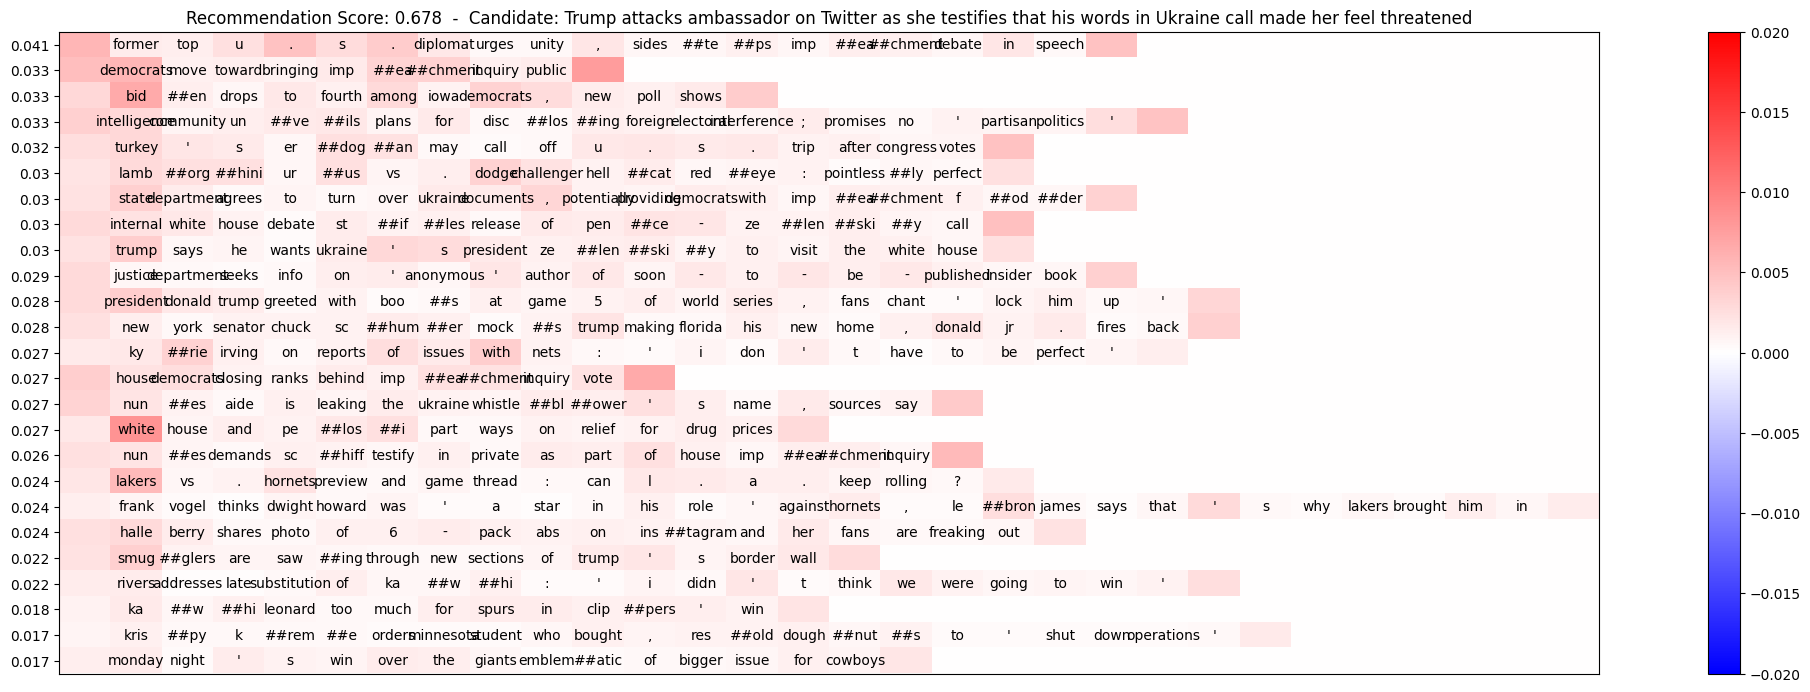

In [19]:
fig = vis.plot_history_attributions(attributions, candidate_title)
fig.show()

The `history_attributions_to_latex()` method turns attributions into code for a latex table which results in a nicer visualization for token attributions.

In [20]:
tex = vis.history_attributions_to_latex(attributions)
print(tex)

0.041 &  \adjustbox{bgcolor=red!18.1}{\strut former} \adjustbox{bgcolor=red!15.7}{\strut top} \adjustbox{bgcolor=red!28.4}{\strut u} \adjustbox{bgcolor=red!57.7}{\strut .} \adjustbox{bgcolor=red!32.1}{\strut s} \adjustbox{bgcolor=red!47.9}{\strut .} \adjustbox{bgcolor=red!21.5}{\strut diplomat} urges unity \adjustbox{bgcolor=red!22.5}{\strut ,} sidesteps imp\adjustbox{bgcolor=red!15.9}{\strut ea}chment debate \adjustbox{bgcolor=red!23.7}{\strut in} speech \\
0.033 &  \adjustbox{bgcolor=red!67.5}{\strut democrats} move \adjustbox{bgcolor=red!15.7}{\strut toward} bringing \adjustbox{bgcolor=red!19.3}{\strut imp}\adjustbox{bgcolor=red!39.5}{\strut ea}\adjustbox{bgcolor=red!42.2}{\strut chment} inquiry \adjustbox{bgcolor=red!17.6}{\strut public} \\
0.033 &  \adjustbox{bgcolor=red!79.8}{\strut bid}\adjustbox{bgcolor=red!16.0}{\strut en} drops \adjustbox{bgcolor=red!21.3}{\strut to} fourth \adjustbox{bgcolor=red!33.9}{\strut among} iowa \adjustbox{bgcolor=red!42.2}{\strut democrats} \adjustb